Define the neural network architecture

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
    )

print(f"Using {device} device")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, stride=1, padding=2)
        self.batchNorm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, 5, stride=1, padding=2)
        self.batchNorm2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 128, 5, stride=1, padding=2)
        self.batchNorm3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(4 * 4 * 128, 2048)
        self.batchNorm4 = nn.BatchNorm1d(2048)

        self.fc2 = nn.Linear(2048, 2048)
        self.batchNorm5 = nn.BatchNorm1d(2048)

        self.out = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchNorm1(x) # batch normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv2(x)
        x = self.batchNorm2(x) # batch normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv3(x)
        x = self.batchNorm3(x) # batch normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = self.fc1(x)
        x = self.batchNorm4(x) # batch normalization
        x = F.relu(x)

        x = self.fc2(x)
        x = self.batchNorm5(x) # batch normalization
        x = F.relu(x)

        x = F.dropout(x, p=0.5)

        x = self.out(x)

        return x

Using cuda device


Load the dataset

In [21]:
import torchvision
import torchvision.transforms as transforms

batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor()]
    )

trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
    )

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True, # reshuffle data at every epoch
    num_workers=2
    )

testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
    )

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
    )

classes = ("plane", "car", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


Function definitions to train, test, and freeze the parameters of the neural network

In [22]:
import matplotlib.pyplot as plt
import numpy as np

''' Train the neural network using backpropagation with cross entropy as the loss function '''
def train_nn(net: nn.Module, epochs: int, optimizer: torch.optim.Optimizer):
  print(f'Initialising training ...')
  print(f'- Epochs: {epochs}')
  print(f'- Batch size: {batch_size}')
  print(f'- Optimiser: {optimizer}')
  print(f'- Loss function: {F.cross_entropy}')

  running_loss_track = []
  accuracy_track = []

  # loop over the dataset multiple times
  for epoch in range(epochs):
    running_loss = 0

    # loop over the dataset and get mini-batch
    for mini_batch_num, data in enumerate(trainloader, 0):
      images = data[0].to(device)
      labels = data[1].to(device)

      optimizer.zero_grad() # zero the parameter gradients

      preds = net(images) # forward mini-batch

      loss = F.cross_entropy(preds, labels) # calculate loss
      loss.backward() # calculate gradients with respect to each weight
      optimizer.step() # update weights

      running_loss += loss.item()

    accuracy = test_nn(net=net, verbose=False)
    print(f'\nEpoch {epoch} finished -- Running loss {running_loss} -- Accuracy {accuracy}')

    # track
    running_loss_track.append(running_loss)
    accuracy_track.append(accuracy)

  # plot
  fig, ax1 = plt.subplots()

  ax1.set_xlabel('Iterations over entire dataset')
  ax1.set_ylabel('Accuracy', color='b')
  ax1.plot(np.array(accuracy_track), '--b', label='Accuracy', linewidth=0.5)

  ax2 = ax1.twinx()
  ax2.set_ylabel('Running Loss', color='r')
  ax2.plot(np.array(running_loss_track), '--r', label='Loss', linewidth=0.5)

  fig.tight_layout()
  fig.legend()
  plt.show()

''' Test the neural network '''
def test_nn(net: nn.Module, verbose: bool):
    # test the neural network
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images = data[0].to(device)
            labels = data[1].to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total

    if verbose:
        print('Testing on 10,000 test images ...')
        print(f'- Correct: {correct}')
        print(f'- Total: {total}')
        print(f'- Accuracy: {accuracy}')

    return accuracy

''' Freeze all the parameters except the last layer and randomize last layer '''
def freeze_parameters(net: nn.Module):
    # freeze all the parameters in the NN
    for param in net.parameters():
        param.requires_grad = False

    # unfreeze all the parameters from the last layer and randomise the weights
    for param in net.out.parameters():
        param.requires_grad = True
        param.data = torch.rand(param.size(), device=device)

Load the pre-trained neural network model and test it to check the accuracy

In [23]:
PATH = './nn-models/cifar10-nn-model'

# load the pretrained NN model
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device=device)

test_nn(net=net, verbose=True)

Testing on 10,000 test images ...
- Correct: 7732
- Total: 10000
- Accuracy: 77


77

NSGA-II

In [26]:
import array
import random
import json
import numpy as np
from deap import base
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
import matplotlib.pyplot as plt

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

LOW_BOUND = -1.0
HIGH_BOUND = 1.0
N_BITS = 8
N_GENERATIONS = 250
MU = 52
CXPB = 0.9
MUTATE_PROB = 0.1

# store all the training dataset in a single batch
ALL_DATA = []
for batch in trainloader:
    ALL_DATA.extend(batch)

# count the number of dimensions of the last layer
N_DIMENSION = 0
for param in net.out.parameters():
    N_DIMENSION += param.numel()

# loss function
def f1(individual):
    # take the parameters from the individual and replace the last layer of the NN with them
    # parameters = decode(individual=individual)
    parameters = torch.as_tensor(individual, dtype=torch.float32, device=device)

    net.out.weight = torch.nn.Parameter(data=parameters[0:20480].reshape(10, 2048))
    net.out.bias = torch.nn.Parameter(data=parameters[20480:20490])
   
    # get a random mini-batch from the training dataset
    with torch.no_grad():
        random_mini_batch = random.randint(0, len(ALL_DATA)-2) 
        if random_mini_batch % 2 == 0:
            images = ALL_DATA[random_mini_batch].to(device)
            labels = ALL_DATA[random_mini_batch+1].to(device)
        else:
            images = ALL_DATA[random_mini_batch-1].to(device)
            labels = ALL_DATA[random_mini_batch].to(device)

        preds = net(images) # forward mini-batch
        loss = F.cross_entropy(preds, labels) # calculate loss

    return loss.item()

# Gaussian regulariser (sum of the square of the weights)
def f2():
    squared_weights = []
    for param_name, param in net.named_parameters():
        squared_weight = torch.square(param.data)
        squared_weights.append(squared_weight)

    sum = 0
    for param in squared_weights:
        sum += torch.sum(param)
        
    return sum.detach().cpu().numpy()

def obj(individual):
    return (f1(individual=individual), f2()) 

# def decode(individual):
#     real_numbers = []
#     for i in range(N_DIMENSION):
#         chromosome = individual[i*N_BITS:(i+1)*N_BITS]
#         bit_string = ''.join(map(str, chromosome))
#         num_as_int = int(bit_string, 2) # convert to int from base 2 list
#         num_in_range = LOW_BOUND + (HIGH_BOUND - LOW_BOUND) * num_as_int / 2**N_BITS
#         real_numbers.append(num_in_range)
    
#     return real_numbers

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox.register("attr_float", uniform, LOW_BOUND, HIGH_BOUND, N_DIMENSION)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", obj)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=LOW_BOUND, up=HIGH_BOUND, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=LOW_BOUND, up=HIGH_BOUND, eta=20.0, indpb=1.0/N_DIMENSION)
toolbox.register("select", tools.selNSGA2)

def nsga_ii():
    # generate initial random population of individuals (parameters)
    pop = toolbox.population(n=MU)

    # evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # this is just to assign the crowding distance to
    # the individuals no actual selection is done
    pop = toolbox.select(pop, len(pop))
    
    # begin the generational process
    for gen in range(1, N_GENERATIONS):
        # vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        
        # selTournamentDCD means Tournament selection based on dominance (D) 
        # followed by crowding distance (CD). This selection requires the 
        # individuals to have a crowding_dist attribute
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        # crossover make pairs of all (even, odd) in offspring
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        # mutation
        for mutant in offspring:
            if random.random() <= MUTATE_PROB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)

        if gen % 10 == 0:
            print(f'generation {gen} finished')

    return pop
        
pop = nsga_ii()

/user/HS400/sr01303/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/user/HS400/sr01303/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


generation 10 finished
generation 20 finished
generation 30 finished
generation 40 finished
generation 50 finished
generation 60 finished
generation 70 finished
generation 80 finished
generation 90 finished
generation 100 finished
generation 110 finished
generation 120 finished
generation 130 finished
generation 140 finished
generation 150 finished
generation 160 finished
generation 170 finished
generation 180 finished
generation 190 finished
generation 200 finished
generation 210 finished
generation 220 finished
generation 230 finished
generation 240 finished


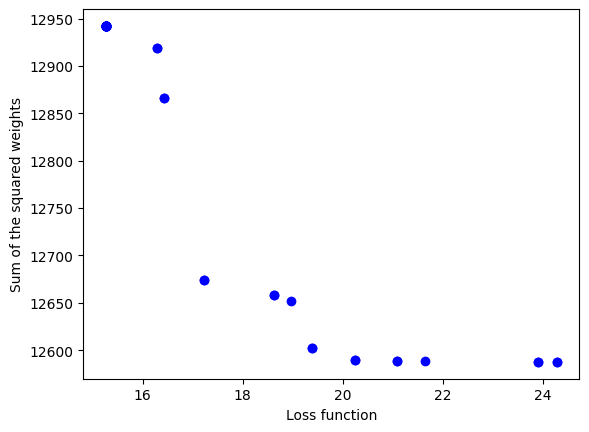

In [27]:
pop.sort(key=lambda x: x.fitness.values)

front = np.array([ind.fitness.values for ind in pop])
plt.scatter(front[:,0], front[:,1], c="b")
plt.axis("tight")
plt.xlabel('Loss function')
plt.ylabel('Sum of the squared weights')
plt.show()

In [34]:
# put best parameters back into the neural network
parameters = torch.as_tensor(pop[random.randint(0, MU-1)], dtype=torch.float32, device=device)
net.out.weight = torch.nn.Parameter(data=parameters[0:20480].reshape(10, 2048))
net.out.bias = torch.nn.Parameter(data=parameters[20480:20490])

# test the neural network
test_nn(net=net, verbose=True)

Testing on 10,000 test images ...
- Correct: 1552
- Total: 10000
- Accuracy: 15


15